In [163]:
import albumentations as A
import cv2
import pandas as pd
import numpy as np
import ast
import random
from PIL import Image
import glob
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.patches as patches
import os
import shutil
from tqdm import tqdm

In [164]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Skin_Disease/1683inst_339imgs.csv')

In [165]:
df

,filename,class,x_center,y_center,bbox_height,bbox_width,image_height,image_width
0,1a.jpeg,Acne scars,0.588000,0.473013,0.004751,0.008451,1334.0,750.0
1,1a.jpeg,Acne scars,0.606667,0.473763,0.009685,0.017227,1334.0,750.0
2,1a.jpeg,Acne scars,0.544000,0.496252,0.014993,0.026667,1334.0,750.0
3,b1.jpeg,Acne scars,0.446667,0.304348,0.017991,0.032000,1334.0,750.0
4,b1.jpeg,Frackels,0.477333,0.213643,0.008996,0.016000,1334.0,750.0
...,...,...,...,...,...,...,...,...
1678,za2.JPG,Acne,0.431548,0.560516,0.035218,0.046958,4032.0,3024.0
1679,za2.JPG,Acne scars,0.466270,0.586062,0.057540,0.076720,4032.0,3024.0
1680,za2.JPG,Acne scars,0.491733,0.503968,0.043155,0.057540,4032.0,3024.0
1681,za2.JPG,Frackels,0.547950,0.618552,0.027461,0.036614,4032.0,3024.0


In [166]:
# attr = ['Frackels', 'Acne scars', 'Acne']
attr = ['Frackels']

df = df[df['class'].isin(attr)]
df['class'].unique()

array(['Frackels'], dtype=object)

In [167]:
# df[df['filename']=='c2.jpeg']

In [168]:
grouped_data = df.groupby('filename').apply(lambda x: [x['class'].tolist(), x.iloc[:, 2:6].values.tolist()]).to_dict()

In [169]:
# Print the grouped data
for filename, data in grouped_data.items():
    print(f"Filename: {filename}")
    print(data[0])
    print(data[1])
    break

Filename: aa1.jpeg
['Frackels', 'Frackels', 'Frackels']
[[0.4425, 0.6475, 0.015, 0.02], [0.47, 0.604375, 0.01, 0.0133333333333333], [0.5525, 0.586875, 0.0075, 0.01]]


In [170]:
aug_df = df.copy()
aug_df = aug_df.truncate(after=-1)
aug_df

,filename,class,x_center,y_center,bbox_height,bbox_width,image_height,image_width


In [171]:
def assign_class(label):
    if label == "Frackels":
        return "0"
    elif label == "Acne scars":
        return "1"
    elif label == "Acne":
        return "2"
    elif label == "Melasma":
        return "3"
    elif label == "Uneven Skin tone":
        return "4"
    elif label == "Mole and Tags":
        return "5"
    elif label == "Wrinkels":
        return "6"
    else:
        return None

In [172]:
def save_augmented_img(trans_img,filename,dir_path):
  full_path = os.path.join(dir_path, filename)
  Image.fromarray(trans_img).save(full_path)

In [173]:
def make_labels_txt(bboxes, labels, filename, dir_path):
  for bbox, label in zip(bboxes, labels):
    try:
        name = filename.split('.')
        path = dir_path + name[0] + '.txt'

        with open(path, 'a') as f:
          x, y, h, w = bbox
          c = assign_class(label=label)

          s = " ".join([str(c), str(x), str(y), str(w),str(h)])
          # print(s)
          f.write(s)
          f.write('\n')

    except FileNotFoundError:
        print("The directory does not exist")

In [174]:
def making_dataframe(aug_df, filename, bboxes, labels, img_w, img_h):
  row_to_add = []
  for bbox, label in zip(bboxes, labels):

    x, y, h, w = bbox
    c = label

    row_to_add.append({
        'filename': filename,
        'class': c,
        'x_center': x,
        'y_center': y,
        'bbox_height': h,
        'bbox_width': w,
        'image_height': img_h,
        'image_width': img_w
    })

  ROWS_to_add = pd.DataFrame(row_to_add)
  aug_df = pd.concat([aug_df, ROWS_to_add], ignore_index=True)  # Concatenate and ignore original index
  # print(aug_df)
  return aug_df

In [175]:
os.mkdir('/content/drive/MyDrive/Colab_Skin_Disease/Augmented/')
os.mkdir('/content/drive/MyDrive/Colab_Skin_Disease/Augmented/images')
os.mkdir('/content/drive/MyDrive/Colab_Skin_Disease/Augmented/labels')

In [176]:
# transform = A.Compose([
#     A.Rotate(limit=(-55,55),always_apply=True),
#     A.HorizontalFlip(p=0.65),
#     A.RandomBrightnessContrast(brightness_limit=(0.00,0.0),contrast_limit=(0.01,0.02),always_apply=True),
#     A.Sharpen(alpha=(0.65,0.85),always_apply=True),
# ], bbox_params = A.BboxParams(format='yolo', min_visibility=0.5, label_fields=['class_labels']))

In [177]:
# Making filters dict
filters = {}

transform = A.Compose([
    A.NoOp()
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['Orignal'] = transform

transform = A.Compose([
 A.CLAHE(clip_limit=(2,2), tile_grid_size=(8,8),always_apply=True),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['CLAHE'] = transform

transform = A.Compose([
    A.Equalize(by_channels=False, always_apply=True)
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['equalize'] = transform

transform = A.Compose([
    A.Emboss(alpha=(1.0, 1.0), strength=(1.0, 1.0), p=1.0),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['emboss'] = transform

transform = A.Compose([
    A.Emboss(alpha=(1.0, 1.0), strength=(1.0, 1.0), p=1.0),
    A.Equalize(by_channels=False, always_apply=True)
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['emboss_equalize'] = transform

transform = A.Compose([
   A.HueSaturationValue (hue_shift_limit=(0,0), sat_shift_limit=(15,15), val_shift_limit=0, always_apply=True),
   A.RandomBrightnessContrast(brightness_limit=(0.1,0.1),contrast_limit=(0.05,0.05),always_apply=True),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['saturtion_brightness'] = transform

transform = A.Compose([
    A.Sharpen(alpha=(1.0, 1.0), lightness=(1.0, 1.0), always_apply=True),
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0, 0), always_apply=True),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['sharpen_brighten'] = transform

transform = A.Compose([
    A.MedianBlur(blur_limit=(9, 9), always_apply=True),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['median_blur'] = transform

transform = A.Compose([
    A.MultiplicativeNoise(multiplier=(0.5, 0.5), per_channel=False, elementwise=False, always_apply=True),
    A.RandomBrightnessContrast(brightness_limit=(0.1, 0.1), contrast_limit=(0.9, 0.9), always_apply=True)
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['multi_noise_brighten'] = transform

transform = A.Compose([
    A.Downscale(scale_min=0.25, scale_max=0.25, interpolation=None, always_apply=True),
],bbox_params = A.BboxParams(format='yolo', label_fields=['class_labels']))
filters['downscale'] = transform

In [178]:
all_imgs_path = '/content/drive/MyDrive/Colab_Skin_Disease/via-2.0.12/'
img_save_path = '/content/drive/MyDrive/Colab_Skin_Disease/Augmented/images/'
label_save_path = '/content/drive/MyDrive/Colab_Skin_Disease/Augmented/labels/'

for filename, bboxes_labels in tqdm(grouped_data.items()):
  for i, (filter_name, filter) in enumerate(filters.items()):
    image = cv2.imread(all_imgs_path + filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height,width = image.shape[:2]

    #<<<<<Transforming>>>>>>
    transformed = filter(image=image, bboxes=bboxes_labels[1], class_labels=bboxes_labels[0])

    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    transformed_class_labels = transformed['class_labels']

    #<<<<Tranforming File Name>>>>
    trans_filename = f"{filename.split('.')[0]}_{filter_name}.{filename.split('.')[1]}"

    #<<<<Making txt files>>>>
    make_labels_txt(transformed_bboxes, transformed_class_labels, trans_filename, label_save_path)
    #<<<<saving the images>>>>
    save_augmented_img(transformed_image,trans_filename,img_save_path)
    #<<<<Making DataFrame>>>>
    aug_df = making_dataframe(aug_df, trans_filename, transformed_bboxes, transformed_class_labels, width, height)
  # break


100%|██████████| 146/146 [06:19<00:00,  2.60s/it]


In [179]:
aug_df

,filename,class,x_center,y_center,bbox_height,bbox_width,image_height,image_width
0,aa1_Orignal.jpeg,Frackels,0.44250,0.647500,0.015000,0.020000,1600.0,1200.0
1,aa1_Orignal.jpeg,Frackels,0.47000,0.604375,0.010000,0.013333,1600.0,1200.0
2,aa1_Orignal.jpeg,Frackels,0.55250,0.586875,0.007500,0.010000,1600.0,1200.0
3,aa1_CLAHE.jpeg,Frackels,0.44250,0.647500,0.015000,0.020000,1600.0,1200.0
4,aa1_CLAHE.jpeg,Frackels,0.47000,0.604375,0.010000,0.013333,1600.0,1200.0
...,...,...,...,...,...,...,...,...
5405,za2_saturtion_brightness.JPG,Frackels,0.54795,0.618552,0.027461,0.036614,4032.0,3024.0
5406,za2_sharpen_brighten.JPG,Frackels,0.54795,0.618552,0.027461,0.036614,4032.0,3024.0
5407,za2_median_blur.JPG,Frackels,0.54795,0.618552,0.027461,0.036614,4032.0,3024.0
5408,za2_multi_noise_brighten.JPG,Frackels,0.54795,0.618552,0.027461,0.036614,4032.0,3024.0


In [182]:
aug_df['filename'].nunique()

1460

In [183]:
aug_df.to_csv('/content/drive/MyDrive/Colab_Skin_Disease/AUGMENTED.csv',index=False)

<h1>Plotting

In [152]:
import pandas as pd
import numpy as np
import cv2
import os
import ast
import random
import shutil
from PIL import Image
import glob
import matplotlib.pyplot as plt
from IPython.display import display
import matplotlib.patches as patches

In [153]:
def load_images_from_folder(folder_path):
    img_dict = {}
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        img_dict[filename] = image_path
    return img_dict

In [154]:
def assign_color(label):
    if label == "Wrinkels":
        return "y"
    elif label == "Melasma":
        return "g"
    elif label == "Frackels":
        return "r"
    elif label == "Acne scars":
        return "b"
    elif label == "Uneven Skin tone":
        return "w"
    elif label == "Mole and Tags":
        return "c"
    elif label == "Acne":
        return "k"
    else:
        return "orange"

In [155]:
def extract_annots(df, file_name):
    anno = []

    df = df[df["filename"] == file_name]

    for index, row in df.iterrows():
        data = {}
        data["bbox_h"] = row['bbox_height']
        data["bbox_w"] = row['bbox_width']

        #Converting Center coordinates to bottom left and right coordinates and doubling the width & height JUST for PLOTTING
        data["cx"] = row['x_center'] - (row['bbox_width'] / 2)
        data["cy"] = row['y_center'] - (row['bbox_height'] / 2)

        data["disease"] = row['class']
        data["color"] = assign_color(label=row['class'])

        data["img_h"] = row['image_height']
        data["img_w"] = row['image_width']

        anno.append(data)
    return anno

In [156]:
def txt_file_annots(file_path):
    anno = []
    # file_path = file_path.replace("/images/", "/val_labels/").replace(".jpeg", ".txt")

    with open(file_path, 'r') as file:
      try:
          lines = file.readlines()
          for line in lines:
              bbox = {}
              line = line.strip().split(' ')
              # c = assign_color(int(line[0]))
              x = float(line[1])
              y = float(line[2])
              w = float(line[3])
              h = float(line[4])
              bbox = {'cx': x, 'cy': y, 'bbox_w': w, 'bbox_h': h}
              anno.append(bbox)

      except ValueError as e:
            print(f"Skipping line: {line} due to error: {str(e)}")

    return anno


In [157]:
def plot(image_path, annots, with_annots=True):
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(img)
    for i in annots:
        try:
            x, y, h, w = i["cx"],i["cy"], i["bbox_h"], i["bbox_w"]
            img_w, img_h, color = i['img_w'], i['img_h'], i["color"]

            # img_w, img_h, color = 1200, 1600, 'b'

            if color != "orange":
              #Multipying with image width and height to DENORMALISE jut for plotting.
              rect = patches.Rectangle((x*img_w, y*img_h), w*img_w, h*img_h, linewidth=0.5, edgecolor=color, facecolor='none')
              ax.add_artist(rect)
        except:
            pass
    plt.show()

In [158]:
# img_save_path = '/content/drive/MyDrive/Colab_Skin_Disease/Augmented/images/'
images = load_images_from_folder('/content/drive/MyDrive/Colab_Skin_Disease/Augmented/images/')

In [159]:
for name, path in images.items():
    # annots = txt_file_annots(path.replace("/images/", "/labels/").replace(".jpeg", ".txt"))
    annots = extract_annots(aug_df,name)
    plot(image_path=path, annots=annots)
    print(name)

Output hidden; open in https://colab.research.google.com to view.

<h1>Testing

In [ ]:
def plot_trans(img,bbox):
  # img = Image.open(img)
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.imshow(img)
  for i in bbox:
    x, y, h, w = i[0],i[1], i[2], i[3]
    img_w, img_h, color = img.shape[1], img.shape[0], 'r'

    x = x - (w/2)
    y = y - (h/2)

    rect = patches.Rectangle((x*img_w, y*img_h), w*img_w, h*img_h, linewidth=0.5, edgecolor=color, facecolor='none')
    ax.add_artist(rect)
  plt.show()

In [ ]:
t = '/content/drive/MyDrive/Colab_Skin_Disease/via-2.0.12/'
f_name = 'jjj1.jpg'
image = cv2.imread(t+f_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes_labels = []
for filename, bboxes in tqdm(grouped_data.items()):
  if filename == f_name:
    print(bboxes[1])
    print(bboxes[0])
    bboxes_labels = bboxes

100%|██████████| 339/339 [00:00<00:00, 606082.29it/s]

[[0.5091666666666667, 0.559375, 0.03, 0.04], [0.6269444444444445, 0.4640972222222222, 0.031875, 0.1516666666666666], [0.3387962962962962, 0.4865277777777778, 0.043125, 0.1383333333333333]]
['Frackels', 'Tear Trough', 'Tear Trough']


In [ ]:
transform = A.Compose([
    A.Rotate(limit=(-55,55),always_apply=True),
    A.HorizontalFlip(p=0.65),
    A.RandomBrightnessContrast(brightness_limit=(0.00,0.0),contrast_limit=(0.01,0.02),always_apply=True),
    A.Sharpen(alpha=(0.65,0.85),always_apply=True),
], bbox_params = A.BboxParams(format='yolo', min_visibility=0.5, label_fields=['class_labels']))

transformed = transform(image=image, bboxes=bboxes_labels[1], class_labels=bboxes_labels[0])

transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']

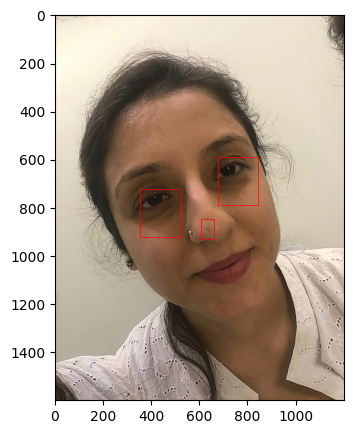

In [ ]:
# plt.imshow(transformed_image)
plot_trans(transformed_image,transformed_bboxes)

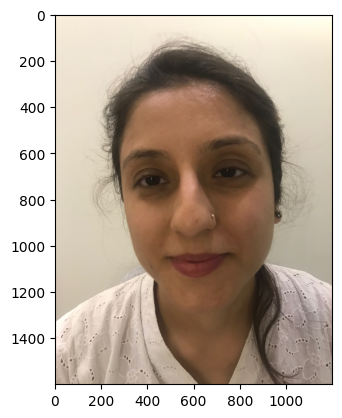

In [ ]:
plt.imshow(image)
plt.show()